In [205]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
import re

In [206]:
def raw_preprocessor(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+|bit\.ly/\S+', 'url_token', text)
    text = re.sub(r'\d+', 'number_token', text)
    return text

In [207]:
spams = pd.read_table("SMSSmapCollection.txt", sep='\t')
spamsTrain, spamsTest = train_test_split(spams, train_size=0.7, random_state=1)

In [208]:
pipe1 = Pipeline([('parse', TfidfVectorizer()), 
                 ('logistic', LogisticRegression())])

pipe2 = Pipeline([('parse', TfidfVectorizer(stop_words='english')), 
                 ('logistic', LogisticRegression())])

pipe3 = Pipeline([('parse', TfidfVectorizer(preprocessor=raw_preprocessor ,stop_words='english', ngram_range=(1, 2))), 
                 ('logistic', LogisticRegression())])

In [209]:
pipe1.fit(spamsTrain['message'], spamsTrain['classe'])
pipe2.fit(spamsTrain['message'], spamsTrain['classe'])
pipe3.fit(spamsTrain['message'], spamsTrain['classe'])

score1 = pipe1.score(spamsTrain['message'], spamsTrain['classe'])
score2 = pipe1.score(spamsTest['message'], spamsTest['classe'])

score3 = pipe2.score(spamsTrain['message'], spamsTrain['classe'])
score4 = pipe2.score(spamsTest['message'], spamsTest['classe'])

score5 = pipe3.score(spamsTrain['message'], spamsTrain['classe'])
score6 = pipe3.score(spamsTest['message'], spamsTest['classe'])

In [210]:
pipelines = {
    "Model 1 (Default)": pipe1,
    "Model 2 (Stopwords)": pipe2,
    "Model 3 (Stopwords + N-grams)": pipe3
}

results = []

for name, pipe in pipelines.items():
    pipe.fit(spamsTrain["message"], spamsTrain["classe"])
    train_score = pipe.score(spamsTrain["message"], spamsTrain["classe"])
    test_score = pipe.score(spamsTest["message"], spamsTest["classe"])

    results.append({
        "Model": name,
        "Training Score": train_score,
        "Testing Score": test_score,
        "Difference": train_score - test_score
    })

results_df = pd.DataFrame(results)
results_df


,Model,Training Score,Testing Score,Difference
0,Model 1 (Default),0.983077,0.975478,0.007598
1,Model 2 (Stopwords),0.980000,0.974282,0.005718
2,Model 3 (Stopwords + N-grams),0.980000,0.980861,-0.000861


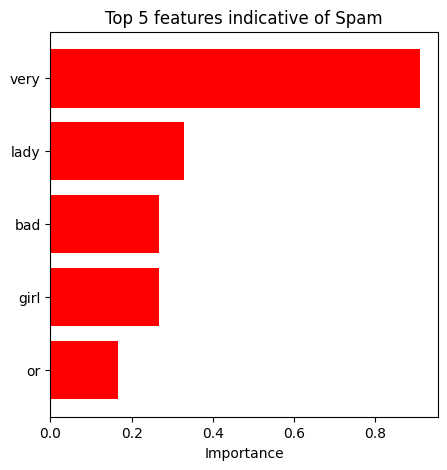

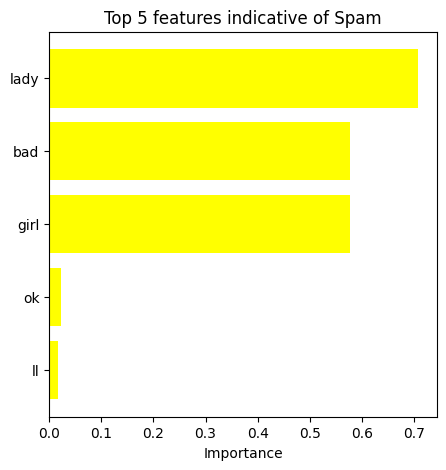

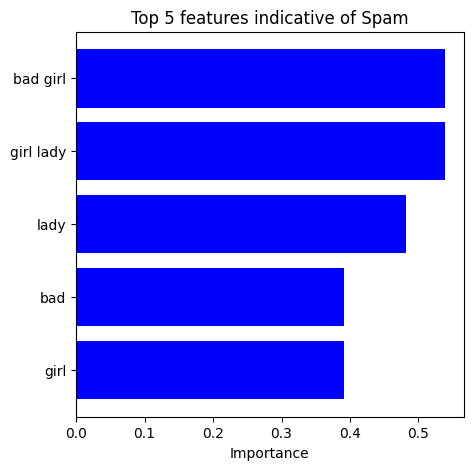

In [211]:
colors = ['red', 'yellow', 'blue']

for (name, pipe), color in zip(pipelines.items(), colors):
    words = pipe.named_steps["parse"].get_feature_names_out()
    weights = pipe.named_steps["logistic"].coef_[0]

    feat_importance = pd.DataFrame({'feature': words, 'importance': weights})

    top_spam = feat_importance.sort_values(by='importance', ascending=False).head(5)

    plt.figure(figsize=(5, 5))
    plt.barh(top_spam['feature'], top_spam['importance'], color=color)
    plt.title('Top 5 features indicative of Spam')
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()
    plt.show()


In [212]:
def make_inference(messages, pipeline):
    
    predictions = pipeline.predict(messages)
    probabilities = pipeline.predict_proba(messages)
    
    results = pd.DataFrame({
        'Message': messages,
        'Prediction': predictions,
        'Confidence': [max(p) for p in probabilities]
    })

    return results

In [213]:

messages = ["WINNER! You have been selected for a cash prize of 5000€. Call 09061701461 to claim now. Terms apply.", # spam
            "Hey Taha, are we still hitting the gym at 6 PM? Let me know if you want to focus on legs today.", # ham
            "Your Amazon package with tracking #99281 has been delayed. Click here to reschedule delivery: bit.ly/fake-link", # spam
            "URGENT: Your password for the ENSAM portal expires in 24 hours. Change it now to avoid lockout.", # ham
            "Can you send me the Python script for the XGBoost stock prediction project? I'm stuck on the data split."] # ham

make_inference(messages=messages, pipeline=pipe3)

,Message,Prediction,Confidence
0,WINNER! You have been selected for a cash priz...,spam,0.902089
1,"Hey Taha, are we still hitting the gym at 6 PM...",ham,0.918983
2,Your Amazon package with tracking #99281 has b...,spam,0.625032
3,URGENT: Your password for the ENSAM portal exp...,ham,0.807597
4,Can you send me the Python script for the XGBo...,ham,0.957746
